# Flawed steel cased well in a layered space

[Lindsey Heagy](http://github.com/lheagy)

SimPEG and the implementation for electrical and electromagnetic methods is described in ([Cockett et al., 2015](https://doi.org/10.1016/j.cageo.2015.09.015) and [Heagy et al., 2017](https://arxiv.org/abs/1610.00804)).

In [1]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import patches
import ipywidgets

import discretize
from discretize import utils
from SimPEG import Utils, Maps
from SimPEG.Survey import Data
from pymatsolver import Pardiso


import casingSimulations as casingSim

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['font.size'] = 14

##  Parameters

To examine the impact of replacing the steel cased well with a solid well, I have run a few simulations using SimPEG and simulating the DC resistivity equations using a finite volume approach on a 3D cylindrical mesh.  

The model setup follows . The electrical conductivities used are:
- Casing $5\times 10^6$ S/m
- Air $3\times10^{-7}$ S/m
- Background $3\times10^{-2}$ S/m
- Inside the casing - same as background

In [3]:
simDir = "dc_flaw_w_layers"

In [4]:
casing_l = 1000
sigma_back = 1e-1
casing_d = 10e-2 #10cm diameter
casing_t = 1e-2 #1cm thickness

model = casingSim.model.FlawedCasingInLayers(
    directory=simDir,
    sigma_casing= 5e6,  # conductivity of the casing (S/m)
    sigma_back = sigma_back,  # conductivity of the background (S/m)
    sigma_inside = sigma_back,  # fluid inside the well has same conductivity as the background
    sigma_air = 1e-4,   # conductivity of the air
    casing_d = casing_d-casing_t,  # 10cm is outer casing diameter
    casing_l = casing_l,
    casing_t = casing_t, 
    layer_tops = [0.],  # 50m thick layer
    sigma_layers = [sigma_back],
    src_a = np.r_[0., 3*np.pi/2., -1.25],  # put the A electrode just below the surface
    src_b = np.r_[1*casing_l, 3*np.pi/2., -1.25] # put the return electrode at a distance of 2 x length of well away
)

# adjust the src_a location so it is connected to well
model.src_a = np.r_[model.casing_r, 3*np.pi/2., -1.25] 

In [5]:
model.serialize()

{'filename': 'ModelParameters.json',
 'directory': 'dc_flaw_w_layers',
 'version': '0.0.6',
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.09000000000000001,
 'casing_t': 0.01,
 'flaw_r': [0.0, 0.0],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [0.0, 0.0],
 'sigma_flaw': 5500000.0,
 'mur_flaw': 1.0,
 'sigma_back': 0.1,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'sigma_layers': [0.1],
 'layer_tops': [0.0],
 'src_a': [0.045000000000000005, 4.71238898038469, -1.25],
 'src_b': [1000.0, 4.71238898038469, -1.25],
 '__class__': 'FlawedCasingInLayers'}

In [6]:
experiment = 1  # 1000 m well, break at 500m, compare with short well

In [7]:
copiedmodelparams = {
    key: val for key, val in model.serialize().items() if key in dir(casingSim.model.CasingInLayers) and not key.startswith('_') 
}

In [8]:
baseline = casingSim.model.CasingInLayers(
    **copiedmodelparams
)

In [9]:
flaw_depth = 500.

model.flaw_r = np.r_[model.casing_a, model.casing_b]
model.flaw_z = np.r_[-10, 0] - flaw_depth
model.sigma_flaw = model.sigma_back

### Set up the models

In [10]:
def random_layers(magnitude_perturbation=1, layer_t=50, seed=3):
    np.random.seed(seed=seed)
    nlayers = int(casing_l / layer_t) + 1
    perturbation = np.random.randn(nlayers)

    log_sigma_layers = (perturbation - perturbation.mean()) / perturbation.sum() * magnitude_perturbation
    log_sigma_layers = log_sigma_layers + np.log(sigma_back)
    sigma_layers = np.exp(log_sigma_layers)
    sigma_layers = sigma_layers * sigma_back / sigma_layers.mean()

    return sigma_layers

In [11]:
layer_t = 50
seeds = [1, 2, 3]

In [12]:
nlayers = int(casing_l / layer_t) + 1
layer_tops = layer_t * np.ones(nlayers - 1)
layer_tops = list(-np.cumsum(np.hstack([[0], layer_tops])))

In [13]:
# percent_perturbation = 5
# layer_t = 50. 
# nlayers = int(casing_l / layer_t) + 1
# perturbation = np.random.randn(nlayers)

# # sigma_layers = percent_perturbation * pertrubation
# log_sigma_layers = (perturbation - perturbation.mean()) / perturbation.sum() * percent_perturbation
# log_sigma_layers = log_sigma_layers + np.log(sigma_back)
# sigma_layers = np.exp(log_sigma_layers)
# sigma_layers = sigma_layers * sigma_back / sigma_layers.mean()

In [14]:
baseline_models = {}
flawed_models = {}

for s in seeds:
    sigma_layers = random_layers(layer_t=layer_t, seed=s)
    
    flawed_noise = model.copy()
    flawed_noise.layer_tops = layer_tops
    flawed_noise.sigma_layers = list(sigma_layers)

    baseline_noise = baseline.copy()
    baseline_noise.layer_tops = layer_tops
    baseline_noise.sigma_layers = list(sigma_layers)
    
    flawed_models["flaw_{}".format(s)] = flawed_noise
    baseline_models["baseline_{}".format(s)] = baseline_noise
    
    print(sigma_back, sigma_layers.mean(), sigma_layers.std())

0.1 0.1 0.02887996087932915
0.1 0.1 0.020143551791193603
0.1 0.10000000000000002 0.03129998136881523


In [15]:
model_names = ['baseline', 'flaw'] + list(baseline_models.keys()) + list(flawed_models.keys())

model_dict = dict(zip(
    model_names[:2], 
    [baseline, model]
))

In [16]:
model_dict.update(baseline_models)
model_dict.update(flawed_models)
model_dict

{'baseline': <casingSimulations.model.CasingInLayers at 0xd214ed080>,
 'flaw': <casingSimulations.model.FlawedCasingInLayers at 0xd214ed828>,
 'baseline_1': <casingSimulations.model.CasingInLayers at 0xd21503b70>,
 'baseline_2': <casingSimulations.model.CasingInLayers at 0xd21503e48>,
 'baseline_3': <casingSimulations.model.CasingInLayers at 0xd21503f60>,
 'flaw_1': <casingSimulations.model.FlawedCasingInLayers at 0xd21503b00>,
 'flaw_2': <casingSimulations.model.FlawedCasingInLayers at 0xd21503dd8>,
 'flaw_3': <casingSimulations.model.FlawedCasingInLayers at 0xd21503eb8>}

In [17]:
for key, val in model_dict.items():
    sigma_layers = np.array(val.sigma_layers)
    print(
        "{}: {:1.2e}, {:1.2e}, {:1.2e}, {:1.2e}".format(
            key, sigma_layers.mean(), sigma_layers.min(), sigma_layers.max(), sigma_layers.std()
        )
    )

baseline: 1.00e-01, 1.00e-01, 1.00e-01, 0.00e+00
flaw: 1.00e-01, 1.00e-01, 1.00e-01, 0.00e+00
baseline_1: 1.00e-01, 5.76e-02, 1.68e-01, 2.89e-02
baseline_2: 1.00e-01, 5.93e-02, 1.42e-01, 2.01e-02
baseline_3: 1.00e-01, 4.98e-02, 1.69e-01, 3.13e-02
flaw_1: 1.00e-01, 5.76e-02, 1.68e-01, 2.89e-02
flaw_2: 1.00e-01, 5.93e-02, 1.42e-01, 2.01e-02
flaw_3: 1.00e-01, 4.98e-02, 1.69e-01, 3.13e-02


## Mesh

Here we set up a 3D cylindrical mesh, discretizing in $x$, $\theta$ and $z$. 

To discretize in x, we start by defining the finest region of the mesh, ensuring that we have 4 cells across the thickness of the casing. From there, we expand the cell sizes until we reach the second uniform cell size we want to model at (`csx2`). We then use a constant cell spacing of `csx2` until we have meshed out to the end of the domain in which we want to examine data (`domainx2`). Beyond that, we add padding cells to *"infinity"*

In [18]:
# hy = utils.meshTensor([(1, 2, -1.5), (1, 3), (1, 2, 1.5)])
hy = np.ones(16)
# hy = np.r_[hy, hy]
hy = hy*2*np.pi / hy.sum()

In [19]:
# parameters defining the core region of the mesh
# note that the finest re
csx2 = 50.  # cell size in the x-direction in the second uniform region of the mesh (where we measure data)
csz = 2.5  # cell size in the z-direction 
domainx2 = 1000  # go out 500m from the well

# padding parameters
npadx, npadz = 15, 22  # number of padding cells
pfx2 = 1.4  # expansion factor for the padding to infinity in the x-direction
pfz = 1.4

# set up a mesh generator which will build a mesh based on the provided parameters
# and casing geometry
cylMeshGen = casingSim.CasingMeshGenerator(
    directory=simDir,  # directory where we can save things
    modelParameters=model,  # casing parameters
    npadx=npadx,  # number of padding cells in the x-direction
    npadz=npadz,  # number of padding cells in the z-direction
    domain_x=domainx2,  # extent of the second uniform region of the mesh 
    hy=hy,   # cell spacings in the 
    csx1=model.casing_t/4.,  # use at least 4 cells per across the thickness of the casing
    csx2=csx2,  # second core cell size
    csz=csz,  # cell size in the z-direction
    pfx2=pfx2,  # padding factor to "infinity"
    pfz=pfz  # padding factor to "infinity" for the z-direction
)

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


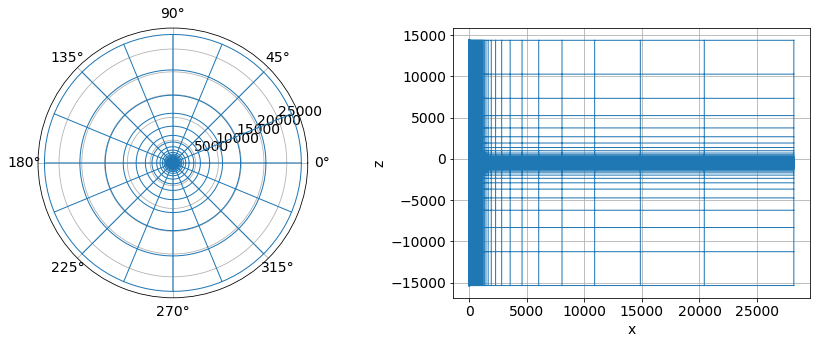

In [20]:
cylMeshGen.mesh.plotGrid()

In [21]:
src_theta = cylMeshGen.hy[0]/2. + np.pi
model.src_a[1] = src_theta
model.src_b[1] = src_theta

(0.0, 3000.0)

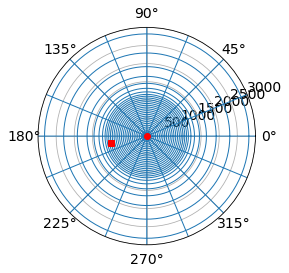

In [22]:
# Plot the source location

ax = plt.subplot(111, projection='polar')
cylMeshGen.mesh.plotGrid(ax=ax, slice='z')
ax.plot(model.src_a[1], model.src_a[0], 'ro')
ax.plot(model.src_b[1], model.src_b[0], 'rs')
ax.set_ylim([0., 3*model.casing_l])

In [23]:
for mod in model_dict.values():
    mod.src_a[1] = src_theta
    mod.src_b[1] = src_theta

In [24]:
# Assign physical properties on the mesh
physpropsDict = dict(
    [
        (name, casingSim.model.PhysicalProperties(cylMeshGen, mod)) 
        for name, mod in model_dict.items()
    ]
)

In [25]:
model_names

['baseline',
 'flaw',
 'baseline_1',
 'baseline_2',
 'baseline_3',
 'flaw_1',
 'flaw_2',
 'flaw_3']

In [26]:
model_dict[model_names[1]].serialize()

{'filename': 'ModelParameters.json',
 'directory': 'dc_flaw_w_layers',
 'version': '0.0.6',
 'sigma_casing': 5000000.0,
 'sigma_inside': 0.1,
 'mur_casing': 1.0,
 'mur_inside': 1.0,
 'casing_top': 0.0,
 'casing_l': 1000.0,
 'casing_d': 0.09000000000000001,
 'casing_t': 0.01,
 'flaw_r': [0.04000000000000001, 0.05],
 'flaw_theta': [0.0, 6.283185307179586],
 'flaw_z': [-510.0, -500.0],
 'sigma_flaw': 0.1,
 'mur_flaw': 1.0,
 'sigma_back': 0.1,
 'mur_back': 1.0,
 'sigma_air': 0.0001,
 'surface_z': 0.0,
 'sigma_layers': [0.1],
 'layer_tops': [0.0],
 'src_a': [0.045000000000000005, 3.3379421944391554, -1.25],
 'src_b': [1000.0, 3.3379421944391554, -1.25],
 '__class__': 'FlawedCasingInLayers'}

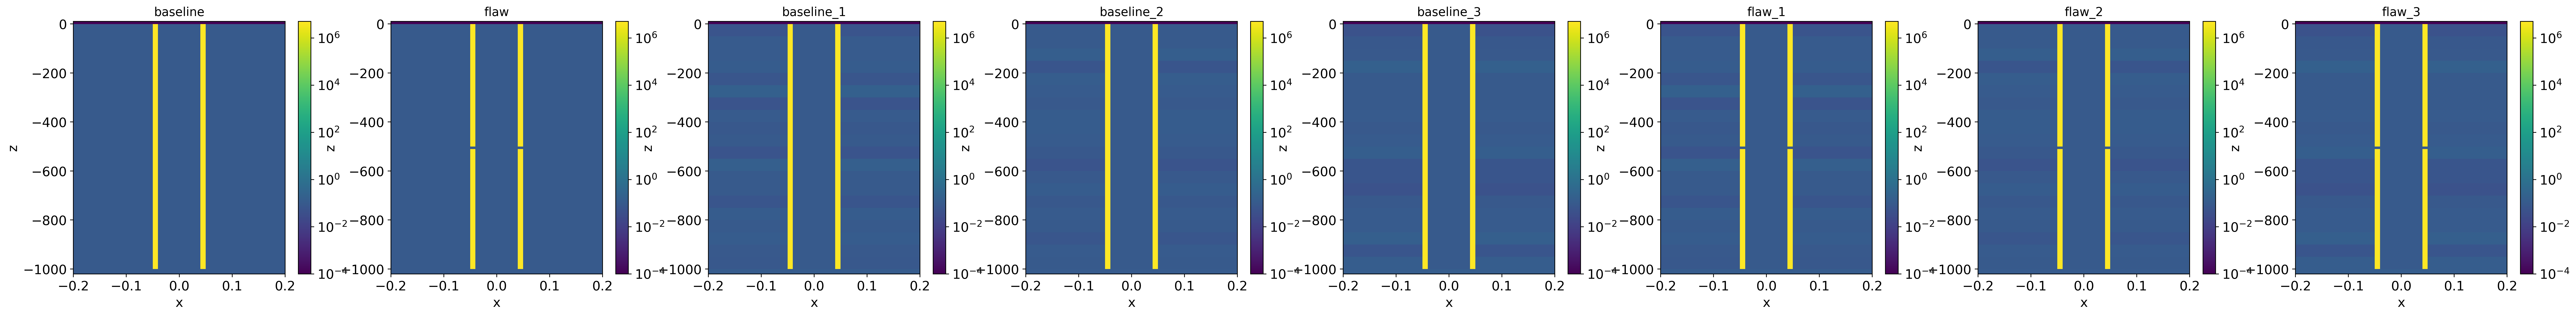

In [27]:
# Plot the models
xlim = 0.2*np.r_[-1, 1]  # x-limits in meters
zlim = np.r_[-casing_l -20, 10]
    

theta_ind = 10

plot_models = model_names

fig, ax = plt.subplots(1, len(plot_models), figsize=(6*len(plot_models), 5), dpi=350)
for a, title in zip(ax, plot_models):
    pp = physpropsDict[title]
    pp.plot_sigma(
        ax=a, 
        theta_ind=theta_ind,
        pcolorOpts={'norm':LogNorm()},  # plot on a log-scale
#         clim = np.r_[1e-6, 1e2]
    )
    a.set_title('{}'.format(title), fontsize=13)
    a.set_xlim(xlim)
    a.set_ylim(zlim)

In [28]:
# Set up 4 sources, top casing, top & not coupled, downhole, downhole not coupled

src_locs = [500]

src_b = np.vstack(
    [[loc, model.src_b[1], model.src_b[2]] for loc in src_locs]
)

src_a = np.ones((src_b.shape[0], 1)) * model.src_a

In [29]:
src_b

array([[500.        ,   3.33794219,  -1.25      ]])

## set up a DC simulation

In [30]:
# model_names = ["baseline", "flawed"]

In [31]:
simDict = {}
for key in model_names:
    simDict[key] = casingSim.run.SimulationDC(
        modelParameters=model_dict[key], directory=simDir, 
        meshGenerator=cylMeshGen, src_a=src_a, src_b=src_b
    )


Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.
Homogeneous Dirichlet is the natural BC for this CC discretization.


In [32]:
%%time
fieldsDict = {}
for title in model_names:
    print('--- Running {} ---'.format(title))
    fieldsDict[title] = simDict[title].run(save=False)
    print('\n')

--- Running baseline ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 55.286827087402344


--- Running flaw ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 45.784162759780884


--- Running baseline_1 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolver.direct.Pardiso'> Solver
   ... Done. Elapsed time : 48.99542498588562


--- Running baseline_2 ---
Validating parameters...
      max x: 28199.41672261712, min z: -15352.855805436326, max z: 14352.855805436311, nC: 682816
Starting SimulationDC
Using <class 'pymatsolve

## Plot Results

Here we plot the radial electric field along a line $90^{\circ}$ from the source. 

In [33]:
def plot_radial_efields(
    ax=None, key="baseline", src_ind=0, xlim=[5., 2000.], theta_ind=1, color_ind=0, 
    label=None, include_baseline=True
):
    if ax is None:
        fig, ax = plt.subplots(1, 3, figsize=(12, 4), dpi=400)
    
    if label is None:
        label=key 
        
#     for i, key in enumerate(model_names):
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]
    baseline_src = simDict['baseline'].survey.srcList[src_ind]
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh, field=np.absolute(f[src,'e']), pltType='semilogy',
        ax=ax[0], theta_ind=theta_ind, xlim=xlim, label=label, color_ind=color_ind
    )
    
    if include_baseline is True: 
        casingSim.view.plotLinesFx(
            cylMeshGen.mesh, field=np.absolute(fieldsDict['baseline'][baseline_src,'e']), pltType='semilogy',
            ax=ax[0], theta_ind=theta_ind, xlim=xlim, label='baseline' if label is None else None, 
            color='k'
        )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f[src,'e'] - fieldsDict['baseline'][baseline_src,'e'])/
            (np.absolute(fieldsDict['baseline'][baseline_src,'e'])+1e-20)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, xlim=xlim,
        label=label, color_ind=color_ind
    )

    ax[0].set_ylabel('Electric Field (V/m)')
    ax[1].set_ylabel('percent difference')
    
    ax[2].set_ylim([0., 100.])
    ax[0].set_title("{:1.1f}\n{:1.1f}".format(src_locs[src_ind], cylMeshGen.mesh.vectorCCy[theta_ind]*180/np.pi))
    
#     [a.set_ylim([1e-7, 1e-3]) for a in ax[:2]]
    [a.legend() for a in ax]

In [34]:
def widget_wrapper(key, src_ind, theta_ind):
#     fig, ax = plt.subplots(1, 2, figsize=(10, 4), dpi=400)
    plot_radial_efields(key=key, src_ind=src_ind, theta_ind=theta_ind)
    plt.tight_layout()
    plt.show()
    
ipywidgets.interact(
    lambda key, src_ind, theta_ind: widget_wrapper(key, src_ind, theta_ind),
    key=ipywidgets.ToggleButtons(options=model_names[1:], value=model_names[1]),
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_locs)-1, value=0),
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=0)
)

interactive(children=(ToggleButtons(description='key', options=('flaw', 'baseline_1', 'baseline_2', 'baseline_…

<function __main__.<lambda>(key, src_ind, theta_ind)>

In [35]:
def widget_wrapper2(key, theta_ind):
    fig, ax = plt.subplots(1, 3, figsize=(10, 4), dpi=400)
    for src_ind in range(len(src_locs)-1):
        plot_radial_efields(
            key=key, src_ind=src_ind, theta_ind=theta_ind, ax=ax, 
            color_ind=src_ind, label="{:1.1e}".format(src_locs[src_ind]),
            include_baseline=False
        )
    ax[2].set_ylim([0, 200])
    plt.tight_layout()
    plt.show()
    
ipywidgets.interact(
    lambda key, theta_ind: widget_wrapper2(key, theta_ind),
    key=ipywidgets.ToggleButtons(options=model_names[1:], value=model_names[1]),
    src_ind=ipywidgets.IntSlider(min=0, max=len(src_locs)-1, value=0),
    theta_ind=ipywidgets.IntSlider(min=0, max=len(cylMeshGen.hy)-1, value=3)
)
# plot_radial_efields(ax=ax, src_ind=0)

interactive(children=(ToggleButtons(description='key', options=('flaw', 'baseline_1', 'baseline_2', 'baseline_…

<function __main__.<lambda>(key, theta_ind)>

In [36]:
from SimPEG import DC

In [37]:
rx_r = cylMeshGen.mesh.vectorCCx[(cylMeshGen.mesh.vectorCCx > 2) & (cylMeshGen.mesh.vectorCCx < 2600)]
rx_y = np.r_[cylMeshGen.mesh.vectorCCy[3]]
rx_z = np.r_[-1.25]
rx = DC.Rx.Pole(utils.ndgrid(rx_r, rx_y, rx_z))

In [38]:
for m in model_names:
    srcList=simDict[m].survey.srcList
    for src in srcList: 
        src.rxList = [rx]

In [39]:
%%time

data_dict = {}
for key in model_names:
    model = physpropsDict[key].model
    simDict[key].prob.model = model
    data_dict[key] = Data(simDict[key].survey, simDict[key].survey.dpred(model, f=fieldsDict[key]))

CPU times: user 1.29 s, sys: 567 ms, total: 1.86 s
Wall time: 1.27 s


In [40]:
for key in model_names:
    simDict[key].survey.dobs = data_dict[key].tovec()

In [41]:
# fig, ax = plt.subplots(1, 1, figsize=(8, 5))
# key=model_names[1]
# DC.Utils.plot_pseudoSection(
#     simDict[key].survey, survey_type='dipole-pole', data_type='volt', 
#     dobs=(data_dict[key].tovec() - data_dict['baseline'].tovec()),
#     scale='linear', ax=ax, clim=np.r_[0., 1.]*1e-2
# )

In [42]:
simDict

{'baseline': <casingSimulations.run.SimulationDC at 0xd2f723160>,
 'flaw': <casingSimulations.run.SimulationDC at 0xd2fba0438>,
 'baseline_1': <casingSimulations.run.SimulationDC at 0xd2fb3a0f0>,
 'baseline_2': <casingSimulations.run.SimulationDC at 0xd2fb3ad30>,
 'baseline_3': <casingSimulations.run.SimulationDC at 0xd2fb3ae48>,
 'flaw_1': <casingSimulations.run.SimulationDC at 0xd2fb85f98>,
 'flaw_2': <casingSimulations.run.SimulationDC at 0xd2fb85518>,
 'flaw_3': <casingSimulations.run.SimulationDC at 0xd2fb7ed68>}

In [43]:
viewer = casingSim.FieldsViewer(
    sim_dict=simDict, fields_dict=fieldsDict, model_keys=model_names
)

In [44]:
viewer.widget_cross_section(defaults={"min_depth":0, "max_depth":casing_l*1.25})

interactive(children=(FloatText(value=0.1, description='max_r'), FloatText(value=0.0, description='min_depth')…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [45]:
viewer.widget_depth_slice(defaults={"z_ind": 426, 'view': 'e', 'max_r':500})

interactive(children=(FloatText(value=500.0, description='max_r'), FloatText(value=0.0, description='clim_min'…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [46]:
mesh = cylMeshGen.mesh

In [47]:
def plot_charge(
    ax=None, key=model_names[0], color_ind=0, color=None, src_ind=0, 
    label=None, secondary=False, linestyle='-', primary_key="baseline"
):
    if ax is None: 
        fig, ax = plt.subplots(1, 1, figsize=(5, 4)) #, dpi=400)
    
    f = fieldsDict[key]
    src = simDict[key].survey.srcList[src_ind]    
    plotme = f[src, 'charge']
    
    if secondary is True:
        f_prim = fieldsDict[primary_key]
        src_prim = simDict[primary_key].survey.srcList[src_ind]
        plotme = plotme - f_prim[src_prim, 'charge']
    z_charges, charges = casingSim.casing_charges(plotme, mesh, mod)
    ax.plot(
        -z_charges, charges, label=label, 
        color=color if color is not None else "C{}".format(color_ind), 
        linestyle=linestyle
    )
        

In [48]:
srcList = simDict[model_names[0]].survey.srcList

In [49]:
len(srcList)

1

In [50]:
from string import ascii_lowercase

In [51]:
rcParams['font.size'] = 12

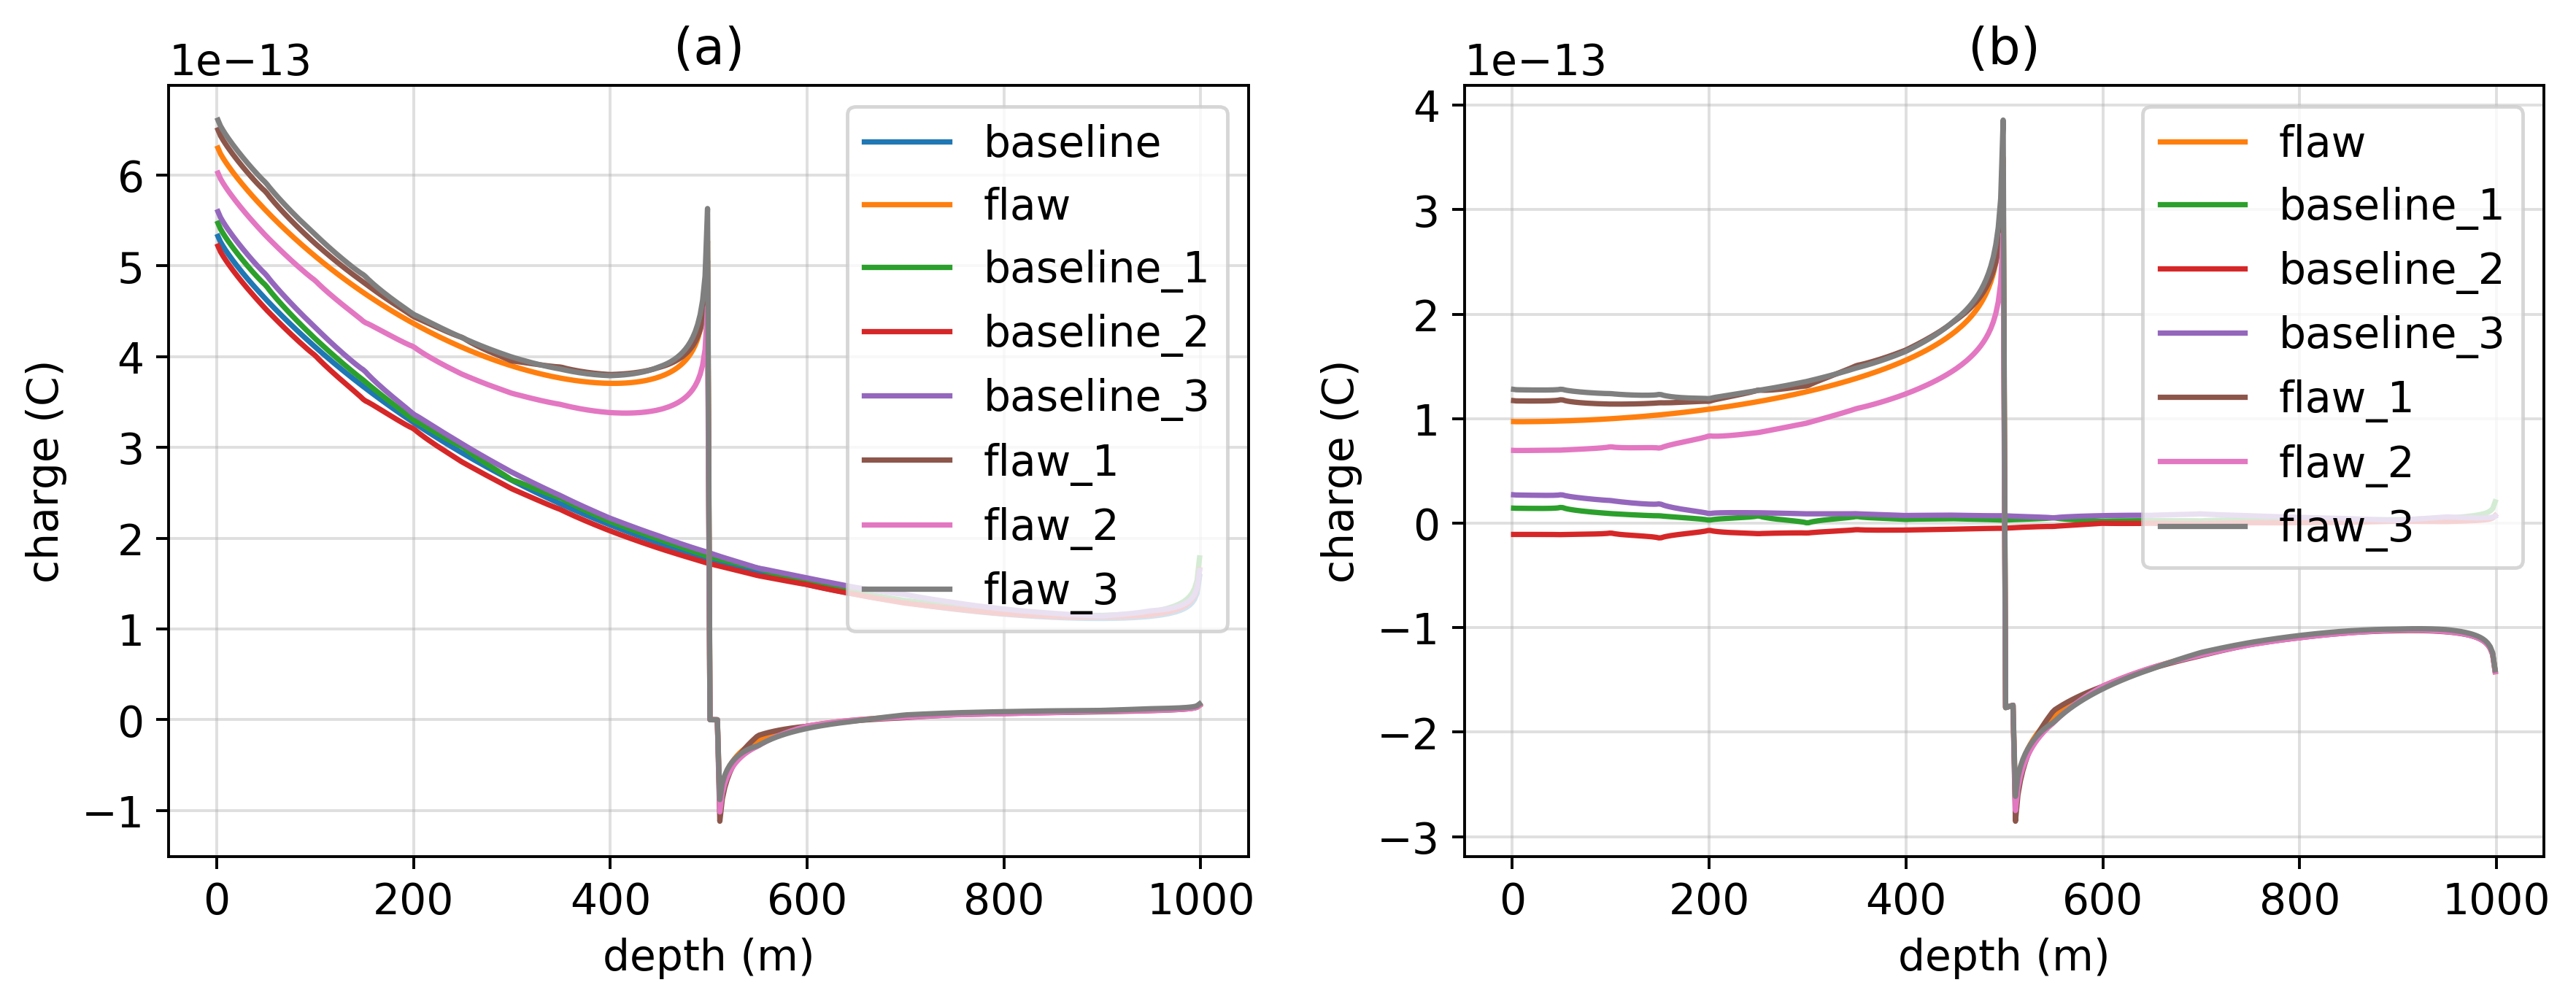

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi = 350)

primary_key = 'baseline'

for i, key in enumerate(model_names):
    plot_charge(ax=ax[0], key=key, color_ind=i, src_ind=len(srcList)-1, label=key)
    if key != primary_key:
        plot_charge(ax=ax[1], key=key, color_ind=i, src_ind=len(srcList)-1, label=key, secondary=True)

for i, a in enumerate(ax):
    a.legend()
    a.set_xlabel('depth (m)')
    a.set_ylabel('charge (C)')
    a.set_title("({})".format(ascii_lowercase[i]))
    a.grid(which='both', alpha=0.4)

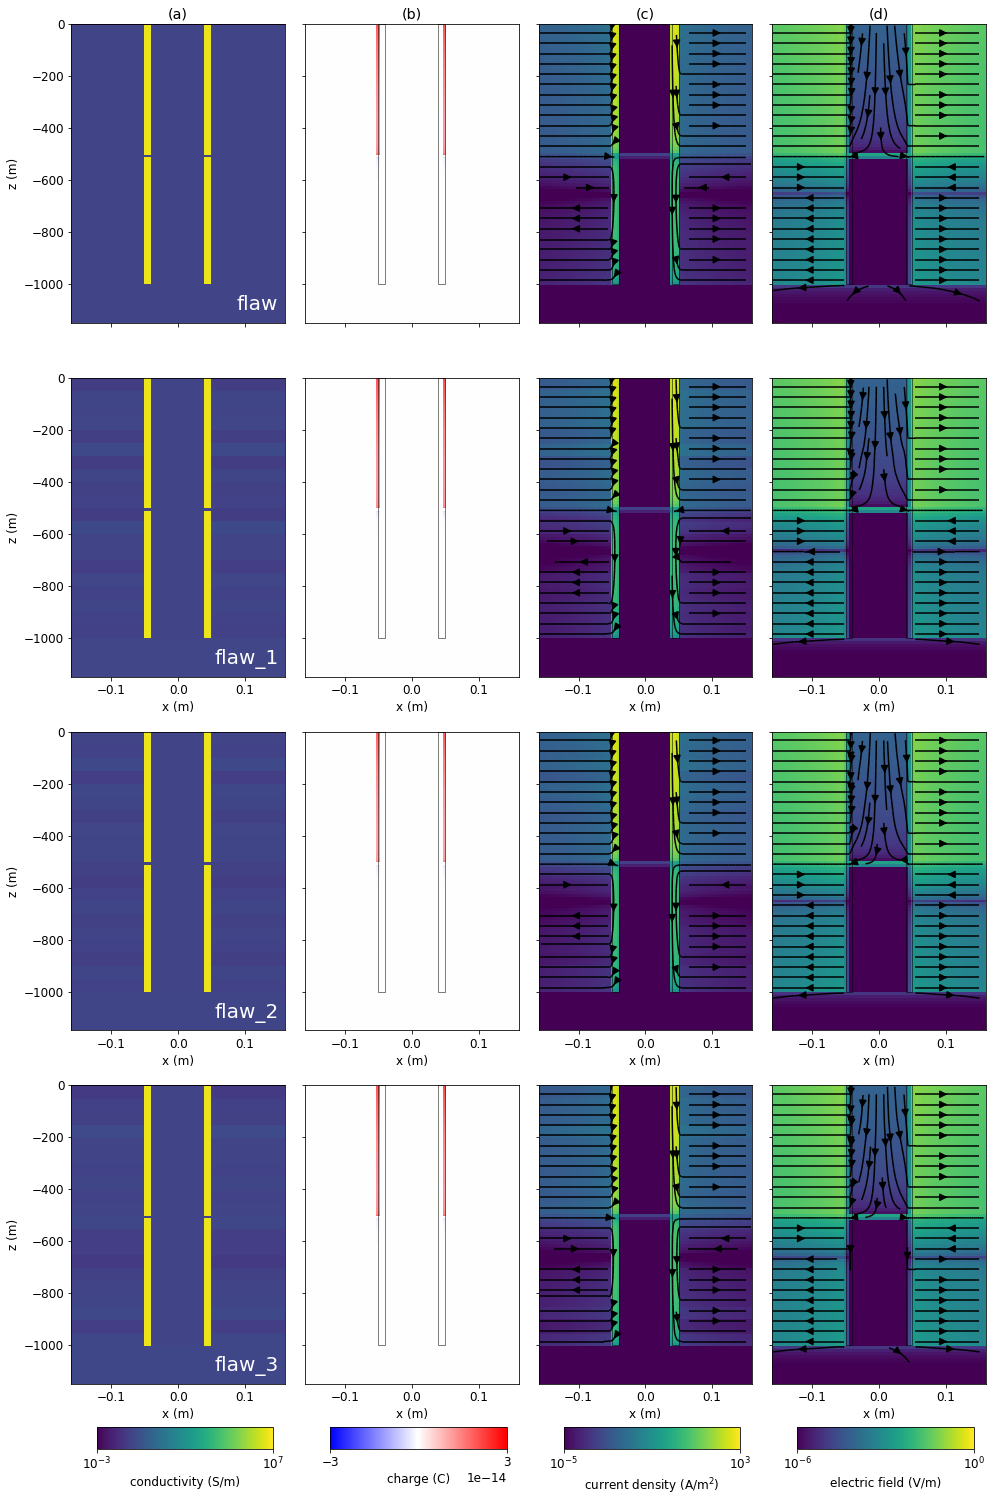

In [53]:
keys = ['flaw'] + ["flaw_{}".format(s) for s in seeds]

fig, ax = plt.subplots(len(keys), 4, figsize=(4*3.5, len(keys)*5))
fig.subplots_adjust(bottom=0.1)

src_ind = 0

max_r = 0.16
min_depth = 0
max_depth = 1150

zlim = np.r_[-max_depth, -min_depth]
xlim = max_r * np.r_[-1., 1.]
stream_opts = {"color":"k", "arrowsize":1.5}

for i, key in enumerate(keys):
    
    sigma_out = viewer.plot_cross_section(
        ax=ax[i][0], 
        clim=np.r_[1e-3, 1e7],
        xlim=xlim, 
        zlim=zlim,
        view='sigma', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=False,
        stream_opts=stream_opts
    )
    ax[i][0].text(
        max_r - 0.01, -max_depth+50, 
        "{}".format(key), 
        color='w', fontsize=20, horizontalalignment="right"
    )
    
    charge_out = viewer.plot_cross_section(
        ax=ax[i][1], 
        clim=3e-14 * np.r_[-1, 1],
        xlim=xlim, 
        zlim=zlim,
        view='charge', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        stream_opts=stream_opts
    )
    
    
    currents_out = viewer.plot_cross_section(
        ax=ax[i][2], 
        clim= np.r_[1e-5, 1e3],
        xlim=xlim, 
        zlim=zlim,
        view='j', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    efields_out = viewer.plot_cross_section(
        ax=ax[i][3], 
        clim= np.r_[1e-6, 1],
        xlim=xlim, 
        zlim=zlim,
        view='e', 
        theta_ind=4, 
        model_key=key, 
        show_cb=False, 
        use_aspect=False,
        casing_outline=True,
        cb_extend='bottom',
        stream_opts=stream_opts
    )
    
    
    if i == 0: 
        for j, a in enumerate(ax[i]):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
            a.set_ylabel('z (m)')
            a.set_title('({})'.format(ascii_lowercase[j]))
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    else:
        for j, a in enumerate(ax[i]):
            a.set_xlabel('x (m)')
            a.set_title('')
            a.set_ylabel('z (m)')
            if j > 0:
                a.set_yticklabels(['']*len(a.get_xticklabels()))
                a.set_ylabel('')
    
# cbar_ax = fig.add_axes([0.25, -0.01, 0.11, 0.01])
# cb_charge = fig.colorbar(charge_out[0], ax=cbar_ax, orientation='horizontal')
        
plt.tight_layout()

for i, out, label in zip(
    np.arange(4), 
    [sigma_out, charge_out, currents_out, efields_out],
    ['conductivity (S/m)', 'charge (C)', 'current density (A/m$^2$)', 'electric field (V/m)'],
#     [None, None, 'min', 'min']
):
    x = ax[1][i].figbox.corners()[0, 0]
    cbar_ax = fig.add_axes([x+0.025, -0.01, 0.175, 0.015])
    cb = fig.colorbar(
        out[0], cbar_ax, orientation="horizontal"
    )
    cb.set_label(label)
    cb.set_ticks([cb.vmin, cb.vmax])
    cb.update_ticks()

plt.show() 

# fig.savefig('integrity_noise_physics', bbox_inches="tight")

In [54]:
cylMeshGen.mesh.hy[0]/2.

0.19634954084936207

In [55]:
from matplotlib import gridspec

In [56]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [57]:
model_names

['baseline',
 'flaw',
 'baseline_1',
 'baseline_2',
 'baseline_3',
 'flaw_1',
 'flaw_2',
 'flaw_3']

## Experiment 3

In [58]:
from string import ascii_lowercase

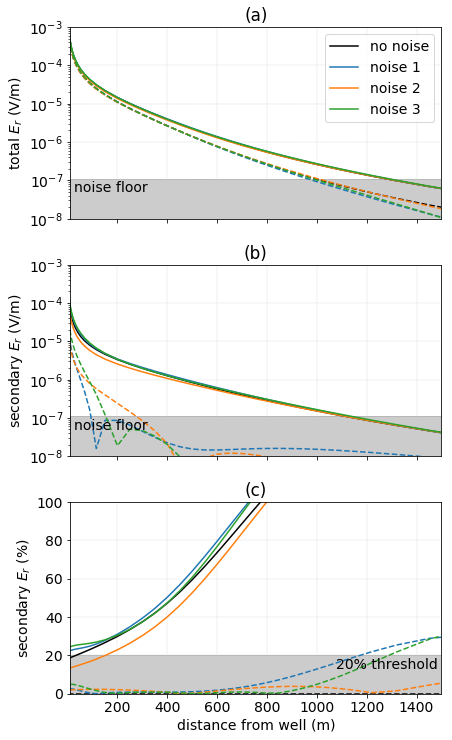

In [59]:
fig, ax = plt.subplots(3, 1, figsize = (6.5, 10.5)) #, dpi=350)
ax = ax.flatten()
src_ind = 0
theta_ind = 4
xlim = [10., 1500.]
ylim = [1e-8, 1e-3]
ylim_percent = [0, 100]
theta_ind = 4

noise_floor = 1e-7
min_percent = 20

eps = 1e-8

primary_key = "baseline"

baseline_key = primary_key
baseline_src = simDict[baseline_key].survey.srcList[src_ind]
baseline_f = fieldsDict[baseline_key][baseline_src, 'e']

flaw_key = "flaw"
flaw_src = simDict[flaw_key].survey.srcList[src_ind]
flaw_f = fieldsDict[flaw_key][flaw_src, 'e']

def plotme(f, label=None, color_ind=None, color=None, linestyle=None):
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=np.absolute(f),
        pltType='semilogy', ax=ax[0], theta_ind=theta_ind,
        label=label, color_ind=color_ind, 
        color=color, linestyle=linestyle
    )
    
    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=(
            np.absolute(f - baseline_f)
        ),
        pltType='semilogy', ax=ax[1], theta_ind=theta_ind, 
        label=label, color_ind=color_ind,
        color=color, linestyle=linestyle
    )

    casingSim.view.plotLinesFx(
        cylMeshGen.mesh,
        field=100*(
            np.absolute(f - baseline_f)/
            (np.absolute(fieldsDict[baseline_key][baseline_src,'e'])+eps)
        ),
        pltType='plot', ax=ax[2], theta_ind=theta_ind, 
        label=label, color_ind=color_ind,
        color=color, linestyle=linestyle
    )


for f, src, linestyle in zip([baseline_f, flaw_f], [baseline_src, flaw_src], ['--', '-']):
    plotme(f, label="no noise" if linestyle == '-' else None, color="k", linestyle=linestyle)

for color_ind, s in enumerate(seeds): 
    
    key_flawed = "flaw_{}".format(s)
    key_intact = "baseline_{}".format(s)
    
    for key, linestyle in zip([key_flawed, key_intact], ['-', '--']):
        src = simDict[key].survey.srcList[src_ind]
        f = fieldsDict[key][src,'e']
        label="{} ".format(key)
        plotme(f, label="noise {}".format(s) if linestyle == '-' else None, color_ind=color_ind, linestyle=linestyle)

ax[0].set_ylim(ylim)
ax[1].set_ylim(ylim)
ax[2].set_ylim(ylim_percent)

ax[0].set_ylabel('total $E_r$ (V/m)')
ax[1].set_ylabel('secondary $E_r$ (V/m)')
ax[2].set_ylabel('secondary $E_r$ (%)')

for i, a in enumerate(ax):
    a.set_title("({})".format(ascii_lowercase[i]))
    if i == 0:
        a.legend(loc=1)
    a.set_xlim(xlim)
    if i < 2:
        a.set_xlabel('')
        a.set_xticklabels(['']*len(a.get_xticklabels()))
        patch = patches.Rectangle(
            [xlim[0], ylim[0]], xlim[1], noise_floor, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[0]+15, noise_floor*0.5, "noise floor")
    else:
        patch = patches.Rectangle(
            [xlim[0], ylim_percent[0]], xlim[1], min_percent, color='k', alpha=0.2
        )
        a.add_patch(patch)
        a.text(xlim[1]-15, min_percent-7, "{}% threshold".format(min_percent), ha="right")        
plt.tight_layout()

# fig.savefig('integrity_noise', bbox_inches="tight", dpi=350)